In [ ]:
import numpy as np
import pandas as pd
import re
from dataclasses import dataclass
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.metrics import confusion_matrix


In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz",
                compression="gzip", low_memory=False)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [10]:
print(df.columns.tolist())

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',

# EDA

In [11]:
df['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [12]:
@dataclass(frozen=True)
class TargetConfig:
    non_default_statuses: tuple = ("fully paid",)
    default_statuses: tuple = ("charged off", "default")

In [13]:
TARGET_COL = "loan_status"
cfg = TargetConfig()

df[TARGET_COL] = df[TARGET_COL].astype(str).str.strip().str.lower()
df["target_default"] = np.where(df[TARGET_COL].isin(cfg.default_statuses), 1,
                         np.where(df[TARGET_COL].isin(cfg.non_default_statuses), 0, np.nan))

before = len(df)
df = df.dropna(subset=["target_default"]).copy()
df["target_default"] = df["target_default"].astype(int)
after = len(df)

print(f"Kept {after:,}/{before:,} rows with clear outcomes.")
print(df["target_default"].value_counts(dropna=False))
print("Default rate:", df["target_default"].mean().round(4))

Kept 1,345,350/2,260,701 rows with clear outcomes.
target_default
0    1076751
1     268599
Name: count, dtype: int64
Default rate: 0.1996


<Axes: xlabel='issue_month'>

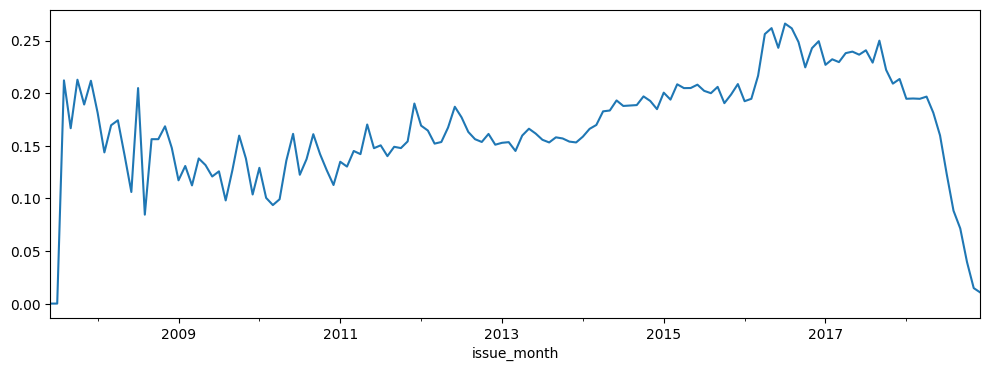

In [14]:
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%Y", errors="coerce")
df["issue_month"] = df["issue_d"].dt.to_period("M").dt.to_timestamp()

monthly = df.groupby("issue_month")["target_default"].mean()
monthly.plot(figsize=(12,4))


(a) 2007–2009: Crisis volatility

- High variance, spikes up to ~22%.

- Small volumes + Global Financial Crisis.

- Data is noisy and unstable.

(b) 2010–2014: Stabilization

- Default rate stabilizes around 12–16%.

- Lending Club improves underwriting and segmentation.

(c) 2015–2017: Systematic risk increase

- Clear upward trend toward 25–27%.

The sharp drop near the end does not mean risk vanished. This is a label-maturity artifact. Late cohorts have not fully seasoned and many risky loans are still marked as “Current” and were excluded.

<Axes: xlabel='grade'>

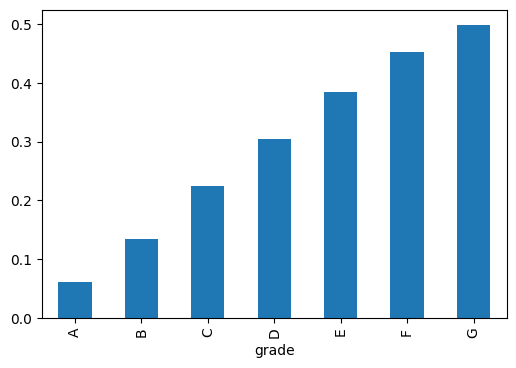

In [15]:
df.groupby("grade")["target_default"].mean().plot(kind="bar", figsize=(6,4))

Lending Club’s grading system is risk-consistent.

<Axes: xlabel='int_rate_bin'>

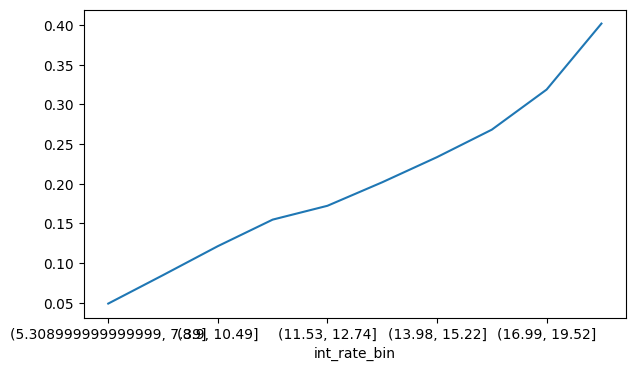

In [17]:
df["int_rate_bin"] = pd.qcut(df["int_rate"], 10)
df.groupby("int_rate_bin", observed=True)["target_default"].mean().plot(figsize=(7,4))


Default risk grows faster than interest income at the high end. Risk is priced into yield.

<Axes: xlabel='fico_avg'>

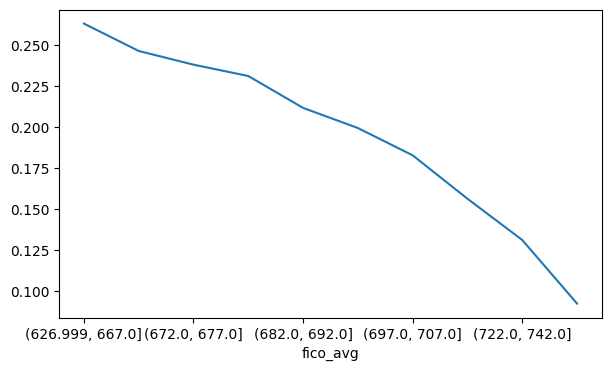

In [18]:
df["fico_avg"] = (df["fico_range_low"] + df["fico_range_high"]) / 2

df.groupby(pd.qcut(df["fico_avg"], 10), observed=True)["target_default"].mean().plot(figsize=(7,4))


[FICO](https://www.investopedia.com/terms/f/ficoscore.asp) behaves as expected.

In [19]:
df.groupby("purpose")["target_default"].mean().sort_values(ascending=False)


purpose
small_business        0.297094
renewable_energy      0.236870
moving                0.233544
house                 0.218914
medical               0.217858
debt_consolidation    0.211491
other                 0.210422
vacation              0.191726
major_purchase        0.186054
home_improvement      0.177186
educational           0.171779
credit_card           0.169287
car                   0.146970
wedding               0.121622
Name: target_default, dtype: float64

<Axes: xlabel='issue_year'>

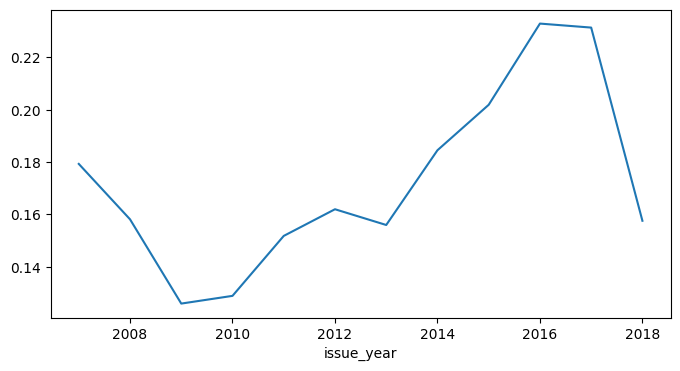

In [20]:
df["issue_year"] = df["issue_d"].dt.year
df.groupby("issue_year")["target_default"].mean().plot(figsize=(8,4))


# Data Preprocessing

In [21]:
# In production, we will NOT know post-issuance behavior at decision time.
# We drop common leakage columns if present.
LEAKAGE_KEYWORDS = (
    "last_", "next_", "recover", "collection", "settlement",
    "pymnt", "payment", "out_prncp", "total_pymnt", "total_rec",
    "chargeoff", "hardship",
)


def is_leakage(col: str) -> bool:
    col = col.lower()
    return any(p in col for p in LEAKAGE_KEYWORDS)

leakage_cols = [c for c in df.columns if is_leakage(c)]
print(f"Identified {len(leakage_cols)} potential leakage columns.")
print(leakage_cols)

Identified 47 potential leakage columns.
['pymnt_plan', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'inq_last_12m', 'chargeoff_within_12_mths', 'sec_app_inq_last_6mths', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settle

In [22]:
# ZIP code was excluded to avoid unfair model from geographic effects.
DROP_COLUMNS = ["loan_status", "url", "desc", "title", "id", "member_id", "zip_code", "emp_title"]

drop_cols = [c for c in leakage_cols] + DROP_COLUMNS
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()
print("Shape after leakage drops:", df_model.shape)

Shape after leakage drops: (1345350, 101)


In [23]:
EXPECTED_CORE_FEATURES = [
    "fico_range_low", "fico_range_high",
    "delinq_2yrs",
    "open_acc", "revol_util",
    "annual_inc", "dti",
    "total_acc"
]

[c for c in EXPECTED_CORE_FEATURES if c not in df_model.columns]


[]

In [24]:
df_model = df_model.sort_values("issue_d")

train_df = df_model[df_model["issue_d"] < "2014-01-01"]
val_df = df_model[(df_model["issue_d"] >= "2014-01-01") & (df_model["issue_d"] < "2016-01-01")]
test_df = df_model[df_model["issue_d"] >= "2016-01-01"]


print("Train shape:", train_df.shape)
print("Validation shape: ", val_df.shape)
print("Test shape: ", test_df.shape)

Train shape: (227957, 101)
Validation shape:  (598649, 101)
Test shape:  (518744, 101)


In [25]:
print(train_df["target_default"].mean())
print(val_df["target_default"].mean())
print(test_df["target_default"].mean())

0.15502046438582714
0.19538327133261726
0.2241857255216446


In [26]:
y_train = train_df["target_default"]
y_val = val_df["target_default"]
y_test = test_df["target_default"]

X_train = train_df.drop(columns=["target_default", "issue_d"])
X_val = val_df.drop(columns=["target_default", "issue_d"])
X_test = test_df.drop(columns=["target_default", "issue_d"])

num_cols = X_train.select_dtypes(include="number").columns.tolist()
cat_cols = X_train.select_dtypes(include="object").columns.tolist()

In [27]:
missing_rate = X_train.isna().mean().sort_values(ascending=False)
print("\nTop missing features (train):")
print(missing_rate.head(20))


Top missing features (train):
open_il_12m                  1.0
revol_bal_joint              1.0
total_cu_tl                  1.0
inq_fi                       1.0
all_util                     1.0
max_bal_bc                   1.0
open_rv_24m                  1.0
open_rv_12m                  1.0
il_util                      1.0
total_bal_il                 1.0
mths_since_rcnt_il           1.0
open_il_24m                  1.0
open_act_il                  1.0
open_acc_6m                  1.0
verification_status_joint    1.0
dti_joint                    1.0
annual_inc_joint             1.0
sec_app_fico_range_low       1.0
sec_app_mort_acc             1.0
sec_app_num_rev_accts        1.0
dtype: float64


In [28]:
structural_missing = missing_rate[missing_rate > 0.99].index.tolist()

len(structural_missing)

27

In [29]:
X_train = X_train.drop(columns=structural_missing)
X_val = X_val.drop(columns=structural_missing)
X_test = X_test.drop(columns=structural_missing)

In [30]:
print("Train shape:", X_train.shape)
print("Validation shape: ", X_val.shape)
print("Test shape: ", X_test.shape)

Train shape: (227957, 72)
Validation shape:  (598649, 72)
Test shape:  (518744, 72)


In [31]:
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=["number"]).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

print("Sample numeric:", numeric_features[:10])
print("Sample categorical:", categorical_features[:10])


Numeric features: 58
Categorical features: 14
Sample numeric: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high']
Sample categorical: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'earliest_cr_line', 'initial_list_status']


# Model Building

In [32]:
# Numeric preprocessing
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
    ]
)

# Categorical preprocessing
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(
            handle_unknown="ignore",
            sparse=True,
            min_frequency=0.01  # groups rare categories
        )),
            ]
)

# Full preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)

# Baseline PD model
pd_model = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="saga",
    max_iter=2000,
    tol=1e-2,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
)

pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", pd_model),
    ]
)


In [33]:
pipeline.fit(X_train, y_train)

# Predict probabilities
p_train = pipeline.predict_proba(X_train)[:, 1]
p_val = pipeline.predict_proba(X_val)[:, 1]

# Metrics
train_auc = roc_auc_score(y_train, p_train)
val_auc  = roc_auc_score(y_val, p_val)

train_brier = brier_score_loss(y_train, p_train)
val_brier  = brier_score_loss(y_val, p_val)

print(f"AUC  - train: {train_auc:.4f}, val: {val_auc:.4f}")
print(f"Brier - train: {train_brier:.4f}, val: {val_brier:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AUC  - train: 0.6812, val: 0.7157
Brier - train: 0.2257, val: 0.2157


In [34]:
n_iter = pipeline.named_steps["model"].n_iter_
print("Iterations used:", n_iter[0])

Iterations used: 36


In [35]:
p_test = pipeline.predict_proba(X_test)[:, 1]

def ks_stat_df(y_true, y_score):
    df_ks = pd.DataFrame({
        "y": y_true.values,
        "score": y_score
    }).sort_values("score")

    cum_bad = df_ks["y"].cumsum() / df_ks["y"].sum()
    cum_good = (1 - df_ks["y"]).cumsum() / (1 - df_ks["y"]).sum()

    return (cum_bad - cum_good).abs().max()

ks_val  = ks_stat_df(y_val, p_val)
ks_test = ks_stat_df(y_test, p_test)

print("KS (val):", ks_val)
print("KS (test):", ks_test)

KS (val): 0.3138998487250009
KS (test): 0.2949108482046047


In [39]:
val_eval = val_df.copy()
val_eval["pd"] = p_val
y_true = val_eval["target_default"]

def policy_metrics(cutoff):
    y_pred = (val_eval["pd"] > cutoff).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    approval_rate = (tn + fn) / len(val_eval)
    default_rate_approved = fn / (tn + fn)

    return approval_rate, default_rate_approved

for c in [0.15, 0.20, 0.30, 0.35]:
    ar, dr = policy_metrics(c)
    print(f"Cutoff {c:.2f} → approval: {ar:.2%}, default (approved): {dr:.2%}")

Cutoff 0.15 → approval: 1.14%, default (approved): 2.97%
Cutoff 0.20 → approval: 3.42%, default (approved): 3.20%
Cutoff 0.30 → approval: 14.59%, default (approved): 5.05%
Cutoff 0.35 → approval: 23.80%, default (approved): 6.28%


- Cutoff = 0.15

    - Ultra-conservative policy

    - We approve only the safest ~1% of applicants

    - Approved portfolio default rate ≈ 3%

- Cutoff = 0.20

    - Conservative but viable

    - Approval rate triples, default rate barely moves

    - We gain volume with almost no deterioration in risk.

- Cutoff = 0.30

    - Balanced risk–return policy

    - Approval rate jumps to ~15%

    - Default rate ≈ 5%

    - Meaningful scale with controlled credit losses.

- Cutoff = 0.35

    - Growth-oriented policy

    - Nearly 1 in 4 applicants approved

    - Default rate rises materially

    - Aggressive growth with rising loss volatility.

In [40]:
def confusion_matrix_df(y_true, pd_scores, cutoff):
    """
    Returns a labeled confusion matrix DataFrame for a given PD cutoff.
    
    Default (1) = bad loan
    Predict default if PD > cutoff (i.e. reject)
    """
    y_pred = (pd_scores > cutoff).astype(int)

    cm = confusion_matrix(y_true, y_pred)

    return pd.DataFrame(
        cm,
        index=[
            "Actual: Non-Default",
            "Actual: Default"
        ],
        columns=[
            "Predicted: Approve",
            "Predicted: Reject"
        ],
    )

for c in [0.15, 0.20, 0.30, 0.35]:
    print(f"\n=== Confusion Matrix @ PD cutoff = {c:.2f} ===")
    display(confusion_matrix_df(y_val, val_eval["pd"], c))


=== Confusion Matrix @ PD cutoff = 0.15 ===


,Predicted: Approve,Predicted: Reject
Actual: Non-Default,6628,475055
Actual: Default,203,116763



=== Confusion Matrix @ PD cutoff = 0.20 ===


,Predicted: Approve,Predicted: Reject
Actual: Non-Default,19823,461860
Actual: Default,656,116310



=== Confusion Matrix @ PD cutoff = 0.30 ===


,Predicted: Approve,Predicted: Reject
Actual: Non-Default,82916,398767
Actual: Default,4406,112560



=== Confusion Matrix @ PD cutoff = 0.35 ===


,Predicted: Approve,Predicted: Reject
Actual: Non-Default,133514,348169
Actual: Default,8942,108024


We rejecting the majority of bad loans, but we also reject many good loans.

# Profit Optimization

In [46]:
LGD = 0.55

def expected_profit(pd, amount, apr, lgd=LGD):
    revenue = amount * apr
    loss = amount * lgd
    return (1 - pd) * revenue - pd * loss

val_eval = val_df.copy()
val_eval["pd"] = p_val

val_eval["exp_profit"] = expected_profit(
    val_eval["pd"],
    val_eval["loan_amnt"],
    val_eval["int_rate"]/100
)

In [47]:
def policy_profit(df, cutoff):
    approved = df[df["pd"] <= cutoff]

    if len(approved) == 0:
        return 0, 0, np.nan

    approval_rate = len(approved) / len(df)
    default_rate  = approved["target_default"].mean()
    total_profit  = approved["exp_profit"].sum()

    return approval_rate, default_rate, total_profit


In [48]:
cutoffs = np.linspace(0.05, 0.50, 46)

rows = []
for c in cutoffs:
    ar, dr, profit = policy_profit(val_eval, c)
    rows.append({
        "cutoff": c,
        "approval_rate": ar,
        "default_rate_approved": dr,
        "expected_profit": profit
    })

profit_df = pd.DataFrame(rows).sort_values("expected_profit", ascending=False)
profit_df.head()


,cutoff,approval_rate,default_rate_approved,expected_profit
7,0.12,0.004833,0.030764,1.114257e+06
6,0.11,0.003438,0.036443,1.102362e+06
5,0.10,0.002492,0.039544,1.042434e+06
8,0.13,0.006458,0.030005,1.012270e+06
4,0.09,0.001732,0.044359,9.183981e+05


In [51]:
test_eval = test_df.copy()
test_eval["pd"] = p_test


test_eval["exp_profit"] = expected_profit(
    test_eval["pd"],
    test_eval["loan_amnt"],
    test_eval["int_rate"]/100
)

CUTOFF = 0.12

approved_test = test_eval[test_eval["pd"] <= CUTOFF]

test_approval_rate = len(approved_test) / len(test_eval)
test_default_rate = approved_test["target_default"].mean()
test_profit = approved_test["exp_profit"].sum()

profit_per_applicant = test_profit / len(test_eval)

print(
    f"TEST POLICY EVALUATION (PD cutoff = {CUTOFF:.2f})\n"
    f"Approval rate        : {test_approval_rate:.2%}\n"
    f"Default rate (approved): {test_default_rate:.2%}\n"
    f"Expected profit       : €{test_profit:,.0f}\n"
    f"Profit per applicant  : €{profit_per_applicant:,.2f}"
)


TEST POLICY EVALUATION (PD cutoff = 0.12)
Approval rate        : 0.69%
Default rate (approved): 3.70%
Expected profit       : €1,149,968
Profit per applicant  : €2.22
